# 6.2: Longest subsequence

$L(j) = 1 + \max \{L(i) : (i, j) \in E\}$

The longest length to a node $L(j)$ is $1+$ the maximum length of all nodes that have an edge into $j$.  
The length of the longest subsequence is the maximimum length to a node.

In [1]:
L = [5, 2, 8, 6, 3, 6, 9, 7]
adj = {i: set(j for j in range(i) if L[j] < L[i]) for i in range(len(L))}
adj

{0: set(),
 1: set(),
 2: {0, 1},
 3: {0, 1},
 4: {1},
 5: {0, 1, 4},
 6: {0, 1, 2, 3, 4, 5},
 7: {0, 1, 3, 4, 5}}

In [3]:
lengths = [0 for _ in range(len(L))]

for i in range(len(lengths)):
    lengths[i] = 1 + max((lengths[j] for j in adj[i]), default=0)
lengths, max(lengths)

([1, 1, 2, 2, 2, 3, 4, 4], 4)

Dynamic programming: compute the max length to a node by relating it to the max length of nodes with edges into the node. Do this in 1 pass, from the base case up.

Dynamic programming is bottom-up. Recursion (with memoization) is top-down. Recursion without memoization is utter insanity.

In [4]:
lengths = [0 for _ in range(len(L))]
prevs = []

for i in range(len(lengths)):
    max_idx = max(adj[i], key=lambda idx: lengths[idx], default=None)
    lengths[i] = 1 + (0 if max_idx is None else lengths[max_idx])
    prevs.append(max_idx)

end_node_idx = max(range(len(lengths)), key=lambda idx: lengths[idx])
print(f"{lengths=}")
print(f"{end_node_idx=}")
print(f"{lengths[end_node_idx]=}")
print(f"{L=}")
print(f"{prevs=}")

idx_path = [end_node_idx]
while idx_path[-1] != None:
    idx_path.append(prevs[idx_path[-1]])
print(f"{idx_path=}")
num_path = list(reversed([L[i] for i in idx_path[:-1]]))
print(f"{num_path=}")

lengths=[1, 1, 2, 2, 2, 3, 4, 4]
end_node_idx=6
lengths[end_node_idx]=4
L=[5, 2, 8, 6, 3, 6, 9, 7]
prevs=[None, None, 0, 0, 1, 4, 5, 5]
idx_path=[6, 5, 4, 1, None]
num_path=[2, 3, 6, 9]


Keep track of index of the maximum length node we came from. Then at the end, backtrack to get the maximum subsequence path.

# 6.3: Edit distance

S-NOWY  
SUNN-Y  

Edit dist (cost) = 3

View 1: ops to change SNOWY -> SUNNY: insert U, replace N -> O, delete W  
View 2: alignment cost: add gap (+1), wrong letter (+1)

Goal: find edit dist b/t $x[1...m]$ and $y[1...n]$.

$E(i, j)$ = edit dist b/t $x[1...i]$ and $y[1...j]$

Goal: compute $E(m, n)$

We need to express $E(i, j)$ in terms of smaller subproblems.

Best alignment b/t $x[1...i]$ and $y[1...j]$:
* $x[i]$ and $\_\_$: $\text{cost} = 1 + E(i-1, j)$
* $\_\_$ and $y[j]$: $\text{cost} = 1 + E(i, j-1)$
* $x[i]$ and $y[i]$: $\text{cost} = (x[i] \neq y[j]) + E(i-1, j-1)$

$E(i, j) = min(1 + E(i-1, j), 1 + E(i, j-1), (x[i] \neq y[j]) + E(i-1, j-1))$

Solution to all subproblems $E(i, j)$ form 2d table.

![Screenshot 2025-01-23 201750.png](<attachment:Screenshot 2025-01-23 201750.png>)

Order to subproblems: must have $E(i-1, j), E(i, j-1), E(i-1, j-1)$ solved before solving $E(i, j)$.  
This can be achieved moving in row-major or col-major order.

Base cases
* $E(0, j) = j$: dist b/t empty prefix of $x$ (empty str) and $y[1...j]$ is $j$
* $E(i, 0) = i$
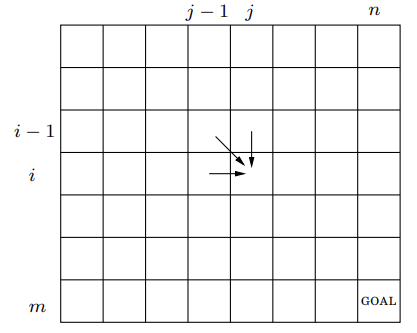

In [33]:
x = "EXPONENTIAL"
y = "POLYNOMIAL"

m = len(x)
n = len(y)

E = [[0 for j in range(n+1)] for i in range(m+1)]
for i in range(m+1):
    for j in range(n+1):
        if i == 0:
            E[i][j] = j
        elif j == 0:
            E[i][j] = i
        else:
            E[i][j] = min(1 + E[i-1][j], 1 + E[i][j-1], (x[i-1]!=y[j-1]) + E[i-1][j-1])

print(f"      {", ".join(y)}")
for i, row in enumerate(E):
    print(f"{x[i-1] if i > 0 else ' '} {row}")
    
print(f"\nE(m, n): {E[m-1][n-1]}")  # E(m, n), the goal

      P, O, L, Y, N, O, M, I, A, L
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
E [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X [2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10]
P [3, 2, 3, 3, 4, 5, 6, 7, 8, 9, 10]
O [4, 3, 2, 3, 4, 5, 5, 6, 7, 8, 9]
N [5, 4, 3, 3, 4, 4, 5, 6, 7, 8, 9]
E [6, 5, 4, 4, 4, 5, 5, 6, 7, 8, 9]
N [7, 6, 5, 5, 5, 4, 5, 6, 7, 8, 9]
T [8, 7, 6, 6, 6, 5, 5, 6, 7, 8, 9]
I [9, 8, 7, 7, 7, 6, 6, 6, 6, 7, 8]
A [10, 9, 8, 8, 8, 7, 7, 7, 7, 6, 7]
L [11, 10, 9, 8, 9, 8, 8, 8, 8, 7, 6]

E(m, n): 6


Fills in the table in row-major order.

O(mn), since O(mn) entries, and each entry takes O(1) time to fill in.

Dynamic programs have underlying DAG (Directed Acyclic Graph) structures. Each node is a subproblem, and edges are dependencies.

Setting all edges to length 1, except for edges going into $(i, j)$ if ($x[i] = y[j]$, the solution is the distance b/t $(0, 0)$ and $(m, n)$. Each step down is a DELETE on x, each step right is an INSERT on y, and each diagonal step is a CHANGE/KEEP on y.

Input $x_1, ..., x_n$, and subproblem is $x_1, ..., x_i$: $O(n)$ subproblems

Inputs $x_1, ..., x_n$ and $y_1, ..., y_n$, and subproblem is $x_1, ..., x_i$ and $y_1, ..., y_i$: $O(nm)$ subproblems

Input $x_1, ..., x_n$, and subproblem is $x_i, ..., x_j$: $O(n^2)$ subproblems

Input rooted tree, subproblem rooted subtree: $O(n)$ subproblems

## Of mice and men
* DNA encoded by 3 billion chars over $\{A, C, G, T\}$
* DNA of people vary by 0.1%, 3 million base positions
* DNA broken down into smaller gene units
* Finding close gene matches gives insight into function
* BLAST algorithm for computational biology

# Knapsack

Robber can carry maximum weight of $W$ pounds.

$n$ items w/ weights $w_1...w_n$ and values $v_1...v_n$

What is the most valuable combo of items he can pick?

$W = 10$


| Item | Weight | Value |
|------|--------|-------|
|  1   |   6    |  30   |
|  2   |   3    |  14   |
|  3   |   4    |  16   |
|  4   |   2    |  9    |

w/ repetitions (infinite # of each item): optimal = item1 + 2 * item2, $48

w/out repetitions (each item once): optimal = item1 + item2, $46

## With repetition